In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

In [2]:
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
from scipy.signal import correlate2d
from scipy.signal import fftconvolve
from scipy.signal import convolve
from scipy.signal import correlate

# Contoh membaca file .mat
#data = sio.loadmat("BG450_model.mat")
data = sio.loadmat("vel.mat")
#print(data.keys())
# Misalkan velocity model ada di key tertentu, misalnya 'velocity_model':
vp = data['vel'].T[100:300]/1000
vp0 = gaussian_filter(vp, 10) #velocity model intial

print(np.min(vp0))
print(np.max(vp0))

vp0.shape

1.5008400969124784
3.342810355265426


(200, 151)

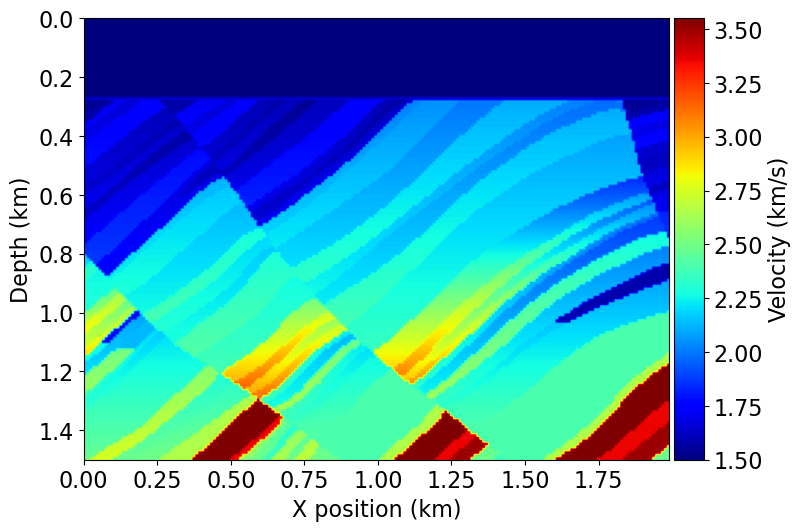

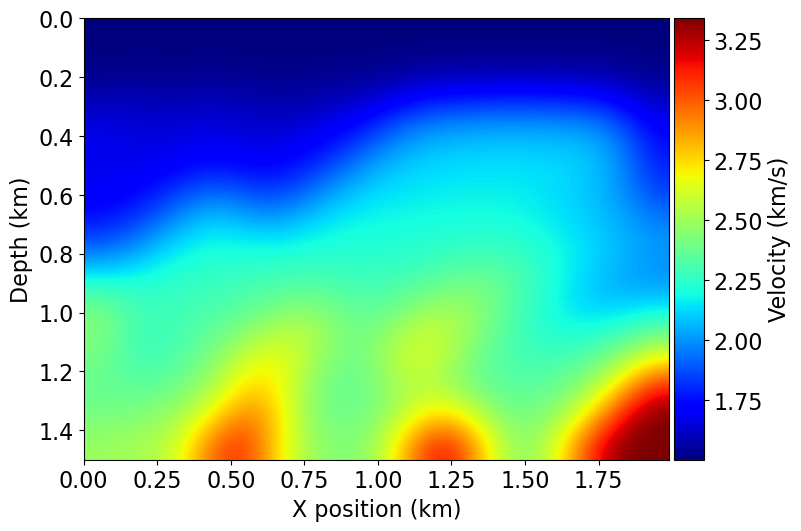

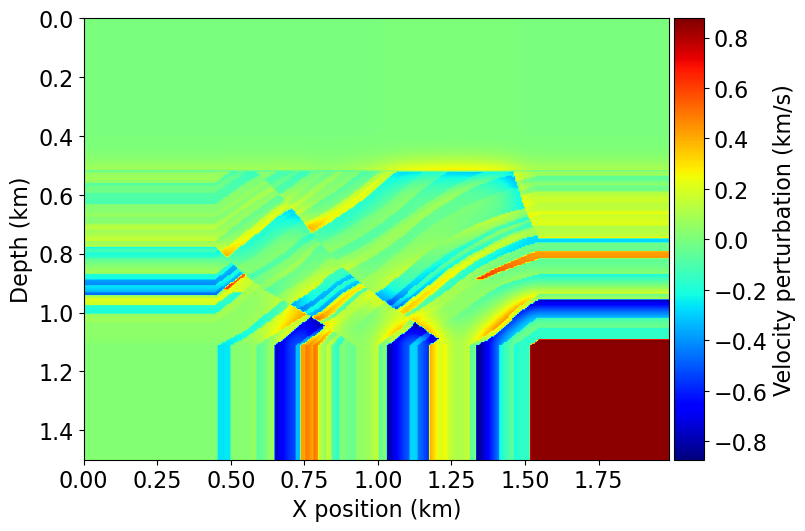

In [3]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity, plot_perturbation, Receiver

# Define a physical size
shape = (vp0.shape)  # Number of grid point (nx, nz)
spacing = (10, 10)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0.,0.)  # What is the location of the top left corner. This is necessary to define
nboundary = 80

model = Model(vp=vp, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp")

model0 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

In [4]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry, TimeAxis, RickerSource

#geometry define
#source geometry
nshots = 11  # Number of shots to create gradient from
shot_first_coordinate = 605
shot_last_coordinate = 1405
shot_depth = 0

#receriver geometry
nreceivers = 120  # Number of receiver locations per shot 
first_channel_firstlreceriverline_coordinate = 10
last_channel_firstreceiverline_coordinate = 1200
receiverline_interval = 80
receiver_depth = 0



#recording define
t0 = 0.
tn = 2000. 
dt = model.critical_dt
time = TimeAxis(start=t0, stop=tn, step=dt)


#source define
f0 = 0.015
shift_phase = 90



In [5]:
# First, position source centrally in all dimensions, then set depth
def geometry_and_source(nshots, shot_first_coordinate, shot_last_coordinate, shot_depth, nreceivers, first_channel_firstlreceriverline_coordinate, last_channel_firstreceiverline_coordinate, receiver_depth, receiverline_interval, t0, tn, dt, f0, shift_phase):
    src_coordinates = np.empty((nshots, 2))
    src_coordinates[:, 0] = np.linspace(shot_first_coordinate, shot_last_coordinate, nshots)
    src_coordinates[:, 1] = shot_depth  # Depth is 20m

    geometrys = []

    for i in range(nshots):
        # Define acquisition geometry: receivers

        # Initialize receivers for synthetic and imaging data
        rec_coordinates = np.empty((nreceivers, 2))
        rec_coordinates[:, 0] = np.linspace(first_channel_firstlreceriverline_coordinate+(i*receiverline_interval), last_channel_firstreceiverline_coordinate+(i*receiverline_interval), nreceivers)
        rec_coordinates[:, 1] = receiver_depth  # Depth is 20m

        # Geometry
        geometry = AcquisitionGeometry(model0, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker', dt=dt)
        geometrys.append(geometry)


    t = np.arange(t0, tn+2, (dt))
    t = t/1000
    f0z = f0*1000
    t0 =   (1/f0z)
    st = (1 - (2*(np.pi**2)*(f0z**2)*(t-t0)**2))*(np.exp(-1*(np.pi**2)*(f0z**2)*(t-t0)**2))

    wavelet = st

    angle = shift_phase
    shifted = np.real(np.exp(1j*np.radians(angle)) * signal.hilbert(wavelet))
    shifted = np.array([shifted])
    shiftedT = shifted.T

    srcs = []

    for i in range(nshots):
        src = RickerSource(name='src', grid=model0.grid, f0=f0, time_range=time)
        # First, position source centrally in all dimensions, then set depth
        src.coordinates.data[0, :] = src_coordinates[i, 0]
        src.coordinates.data[0, -1] = shot_depth  # Depth is 20m
        src.data[:] = shiftedT
        srcs.append(src)

    return geometrys, srcs

In [6]:
geometrys, srcs = geometry_and_source(nshots, shot_first_coordinate, shot_last_coordinate, shot_depth, nreceivers, first_channel_firstlreceriverline_coordinate, last_channel_firstreceiverline_coordinate, receiver_depth, receiverline_interval, t0, tn, dt, f0, shift_phase)

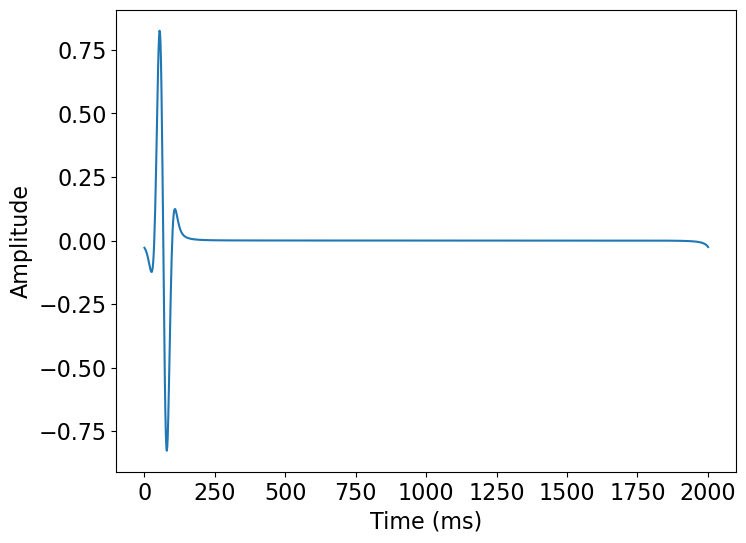

TimeAxis: start=0, stop=2001, step=1.725, num=1161


In [7]:
srcs[0].show()
srcs[0].data.shape

print(geometrys[0])
print(geometrys[0].time_axis)

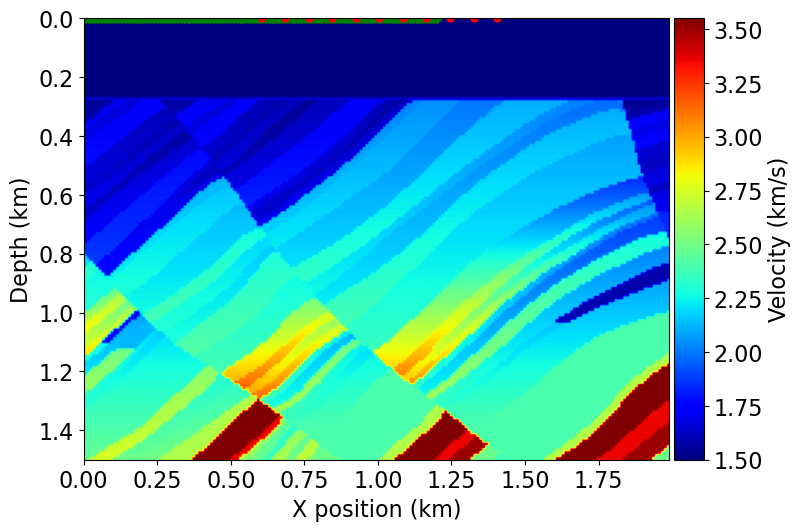

In [8]:
#NBVAL_IGNORE_OUTPUT
# Plot acquisition geometry
plot_velocity(model, source=geometrys[0].src_positions, receiver=geometrys[0].rec_positions)

In [9]:
# Mencari indeks geophone terdekat untuk setiap shot
geometry = geometrys[0]
nearest_indices = []
i=0
for shot in geometry.src_positions:
    distances = np.linalg.norm(geometrys[i].rec_positions - shot, axis=1)  # Hitung jarak Euclidean
    nearest_index = np.argmin(distances)  # Cari indeks dengan jarak minimum
    nearest_indices.append(nearest_index)
    i+=1

In [10]:
print(nearest_indices)

[59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59]


In [11]:
data_obs = []

for i in range(nshots):
        # Compute synthetic data with forward operator 
        from examples.seismic.acoustic import AcousticWaveSolver

        solver = AcousticWaveSolver(model, geometrys[i], space_order=2)

        d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometrys[i].time_axis, 
                         coordinates=geometrys[i].rec_positions)
        # Update source location
        #geometry.src_positions[0, :] = src_coordinates[i, :]

        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, src=srcs[i], rec=d_obs)

        data_obs.append(np.array(d_obs.data[:]))

data_obs = np.array(data_obs)

In [12]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn, kg):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # Data ukuran (1920 x 120)
        data_1 = dsyn.data[:]
        data_2 = dobs.data[:]

        # Data ukuran (1920 x 120)
        

        # Pastikan data_2 menjadi array 1D untuk keperluan konvolusi
        filter_data1 = dobs.data[:,kg]
        filter_data2 = dsyn.data[:,kg]


        for i in range(residual.data.shape[1]):
            # Panjang data asli
            len_data1 = len(data_1)

            # Panjang hasil korelasi
            len_full = len(convolve(filter_data1, data_1[:, i], mode='full'))

            # Indeks untuk mengambil nilai tengah
            start = (len_full - len_data1) // 2
            end = start + len_data1
            
            residual.data[:, i] = convolve(data_1[:, i], filter_data1, mode='full')[:len_data1] - convolve(data_2[:, i], filter_data2, mode='full')[:len_data1]
            
         # Data berukuran (1920 x 1)
        
        data_1 = dobs.data[:,kg]

        # Data berukuran (1920 x 120)
        data_2 = residual.data[:]    
        # Menyimpan hasil cross-correlation
        cross_correlations = []
        len_data = len(data_1)
        # Lakukan cross-correlation untuk setiap kolom di data_2
        for i in range(data_2.shape[1]):
            result = correlate(data_2[:, i], data_1, mode='full')[len_data-1:]
            cross_correlations.append(result)
        residual.data[:] = np.array(cross_correlations).T
        
        #residual.data[:] = ((residual.data[:] - residual.data[:].min())/(residual.data[:].max()-residual.data[:].min()))*((dobs.data[:].max()-dobs.data.min())+dobs.data.min())
    return residual

In [13]:
def misfit(vp_in):
    objective = 0.
    for i in range(nshots):
        # Compute synthetic data with forward operator 
        from examples.seismic.acoustic import AcousticWaveSolver

        solver = AcousticWaveSolver(model0, geometrys[i], space_order=2)
        
        # Create placeholders for the data residual and data
        residual = Receiver(name='residual', grid=model0.grid,
                            time_range=geometrys[i].time_axis, 
                            coordinates=geometrys[i].rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometrys[i].time_axis, 
                         coordinates=geometrys[i].rec_positions)
        d_syn = Receiver(name='d_syn', grid=model0.grid,
                        time_range=geometrys[i].time_axis, 
                        coordinates=geometrys[i].rec_positions)
        # Update source location
        #geometry.src_positions[0, :] = src_coordinates[i, :]

        # Generate synthetic data from true model
        #_, _, _ = solver.forward(vp=model.vp, src=srcs[i], rec=d_obs)
        d_obs.data[:] = data_obs[i]

        # Compute smooth data and full forward wavefield u0
        _, _, _ = solver.forward(vp=vp_in.vp, src=srcs[i], rec=d_syn)

        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn, nearest_indices[i])
        objective += 0.5*norm(residual)**2
    return objective
    

In [29]:
def cubic_interpolation(alpha0, alpha1, f0, f1, df0, df1):
    """
    alpha0 = 0 (biasanya)
    alpha1 = nilai alpha awal (misal 1)
    f0, f1 = nilai fungsi misfit di alpha0 dan alpha1
    df0, df1 = arah turun di alpha0 dan alpha1 (dot product grad * direction)
    """

    d1 = df0 + df1 - 3 * ((f0 - f1) / (alpha0 - alpha1))
    d2 = np.sign(alpha1 - alpha0) * np.sqrt(d1**2 - df0 * df1)

    alpha_new = alpha1 - (alpha1 - alpha0) * (df1 + d2 - d1) / (df1 - df0 + 2*d2)
    # Batas aman: jangan keluar dari range
    alpha_new = max(0.1 * alpha1, min(alpha_new, 0.9 * alpha1))
                    
    return alpha_new

def linesearch(vp_in, ff, g, p, a=0.0001, b=0.1, l=1):
    from copy import deepcopy
    import numpy as np

    max_iter = 10
    ni = 0
    gtp = np.sum(g * p)  # gradien awal dot arah
    best_l = None
    best_ff2 = None

    while ni < max_iter:
        vp2 = deepcopy(vp_in)
        vp2.vp.data[:] = vp_in.vp.data[:] + l * p
        ff2 = misfit(vp2)
        _, g2 = fwi_gradient(vp2.vp)
        g2tp = np.sum(g2.data[:] * p)

        # Cek sufficient decrease (Armijo)
        if ff2 <= ff + a * l * gtp:
            # Simpan sebagai kandidat terbaik jika Armijo terpenuhi
            if best_l is None or l > best_l:
                best_l = l
                best_ff2 = ff2

            # Cek curvature condition
            if abs(g2tp) <= b * abs(gtp):
                print(f"Strong Wolfe satisfied, l : {l}")
                return l  # Strong Wolfe satisfied
            else:
                l *= 5
                print(f"Armijo satisfied but curvature not satisfied, l : {l}")
        else:
            if g2tp <= b * gtp:
                l = cubic_interpolation(0, l, ff, ff2, gtp, g2tp)
                print(f"Armijo not satisfied, but curvature satisfied, l : {l}")
            else:
                if l >= 5:
                    l = cubic_interpolation(0, l, ff, ff2, gtp, g2tp)
                    print(f"Neither Wolfe condition satisfied, l : {l}")
                else:
                    l *= 5
                    print(f"Neither Wolfe condition satisfied, l : {l}")
        ni += 1

    # Jika tidak menemukan step length yang memenuhi strong Wolfe,
    # kembalikan step length terbaik yang hanya memenuhi Armijo (jika ada)
    if best_l is not None:
        print(f"Strong Wolfe not satisfied. Returning best Armijo-satisfying l : {best_l}")
        return best_l
    else:
        print(f"No condition satisfied. Returning last tried l : {l}")
        return l




def cg(g0, g1, p):
  B = np.sum(g1*g1)/np.sum(g0*g0)
  p = -1*g1[:] + B*p
  return p

In [15]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver, plot_shotrecord

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    
    objective = 0.
    for i in range(nshots):
        # Compute synthetic data with forward operator 
        from examples.seismic.acoustic import AcousticWaveSolver

        solver = AcousticWaveSolver(model0, geometrys[i], space_order=2)
        
        # Create placeholders for the data residual and data
        residual = Receiver(name='residual', grid=model.grid,
                            time_range=geometrys[i].time_axis, 
                            coordinates=geometrys[i].rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                         time_range=geometrys[i].time_axis, 
                         coordinates=geometrys[i].rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometrys[i].time_axis, 
                        coordinates=geometrys[i].rec_positions)

        
        # Update source location
        #geometry.src_positions[0, :] = src_coordinates[i, :]

        # Generate synthetic data from true model
        #_, _, _ = solver.forward(vp=model.vp, src=srcs[0i, rec=d_obs)
        d_obs.data[:] = data_obs[i]

        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, src=srcs[i], rec=d_syn)
        
        #plot_shotrecord(d_syn.data[:], model0, t0,tn)
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn, nearest_indices[i])
        
        objective += .5*norm(residual)**2
        
        #plot_shotrecord(residual.data, model, t0, tn)
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
        
        
    gradNormalized = Function(name="gradNormalized", grid=model.grid)
    grad.data[:] *= watermute.data[:]
    #grad.data[:] *= modelpadmute.data[:]
    #Normalisasi ke rentang [-1, 1]
    gradNormalized.data[:] = (grad.data)/np.abs(grad.data[:]).max()
    
        

    return objective, gradNormalized

In [16]:
waterheight = 27
watermute = Function(name="watermute", grid=model.grid)
watermute.data[:,nboundary+waterheight:] += 1

In [17]:
modelpad = 160
modelpadmute = Function(name="modelpadmute", grid=model.grid)
modelpadmute.data[nboundary+modelpad:,:] += 1
#modelpadmute.data[280-(nboundary+modelpad):280,:] = 0

modeli =[]
misfiti = []
gradi = []

mu = 0.05
lamb = []

update_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
#plot_velocity(update_model)

modeli.append(update_model)

fwi_iterations = 5  # Number of outer FWI iteration
fwi_index = 1
for i in range(fwi_iterations):
    ff, update = fwi_gradient(update_model.vp)

    misfiti.append(ff)
    gradi.append(update)
    
    print(f"iterasi ke-{i} : {ff}")
    
    a = 0.25
    b = 0.5
    L = 100

    L = linesearch(a, b, L, update_model, ff,  update, mu, lamb)

    
    update_model.vp.data[:] += (L*update.data[:]/1000)
    modeli.append(update_model)
    
    if i >= 2 :
        if (np.abs(ff-misfiti[i-1]))<1e-3:
            break
    fwi_index+=1

ff, update = fwi_gradient(update_model.vp)
misfiti.append(ff)
gradi.append(update)

print(f"iterasi ke-{fwi_index} : {ff}")

In [103]:
from copy import deepcopy

multiscale_freq = np.array([15.])
multiscale_freq /= 1000

modelbest_each_freq = []

misfiti = []
gradi = []

update_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
            space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)

for k in multiscale_freq:
    print(f"Proses FWI freq {k}")

    geometrys, srcs = geometry_and_source(nshots, shot_first_coordinate, shot_last_coordinate, shot_depth, nreceivers, first_channel_firstlreceriverline_coordinate, last_channel_firstreceiverline_coordinate, receiver_depth, receiverline_interval, t0, tn, dt, k, shift_phase)
    

    # Mencari indeks geophone terdekat untuk setiap shot
    geometry = geometrys[0]
    nearest_indices = []
    i1=0
    
    for shot in geometry.src_positions:
        distances = np.linalg.norm(geometrys[i1].rec_positions - shot, axis=1)  # Hitung jarak Euclidean
        nearest_index = np.argmin(distances)  # Cari indeks dengan jarak minimum
        nearest_indices.append(nearest_index)
        i1+=1
    
    
    modeli =[]
    gradi = []
    #plot_velocity(update_model)
    model_update = deepcopy(update_model)
    modeli.append(model_update)

    fwi_iterations = 5  # Number of outer FWI iteration
    fwi_index = 1
    for i in range(fwi_iterations):
        if i==0 :
            ff, update = fwi_gradient(update_model.vp)

            gradient = -1*update.data[:]

        else :
            ff, update1 = fwi_gradient(update_model.vp)

            gradient1 = -1*update1.data[:]

            update.data[:] = cg(gradient, gradient1, update.data[:])

            gradient = deepcopy(gradient1)


        misfiti.append(ff)
        gradi.append(update)
    
        print(f"FWI freq {k} iterasi ke-{fwi_index}/{fwi_iterations} : {ff}")
    

        L = linesearch(update_model, ff, gradient, update.data[:], a=0.0001, b=0.5, l=0.1)

    
        update_model.vp.data[:] += (L*update.data[:])
        modeli.append(update_model)
    
        if i >= 2 :
            if (np.abs(ff-misfiti[i-1]))<1e-3:
                break
        fwi_index+=1

    ibest = 0
    min_misfit= 9999
    for l in range(len(misfiti)):
        if misfiti[l]<min_misfit:
            min_misfit = misfiti[l]
            ibest = l
    

    modelbest_each_freq.append(update_model)

Proses FWI freq 0.015
FWI freq 0.015 iterasi ke-1/5 : 8657593107950952.0
FWI freq 0.015 iterasi ke-2/5 : 8624851669074776.0
FWI freq 0.015 iterasi ke-3/5 : 8547878985130848.0
FWI freq 0.015 iterasi ke-4/5 : 8536517048926728.0
FWI freq 0.015 iterasi ke-5/5 : 8522834714132696.0


In [30]:
from copy import deepcopy

multiscale_freq = np.array([5.])
multiscale_freq /= 1000

modelbest_each_freq = []

misfiti = []
gradi = []

update_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
            space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)

for k in multiscale_freq:
    print(f"Proses FWI freq {k}")

    geometrys, srcs = geometry_and_source(nshots, shot_first_coordinate, shot_last_coordinate, shot_depth, nreceivers, first_channel_firstlreceriverline_coordinate, last_channel_firstreceiverline_coordinate, receiver_depth, receiverline_interval, t0, tn, dt, k, shift_phase)
    

    # Mencari indeks geophone terdekat untuk setiap shot
    geometry = geometrys[0]
    nearest_indices = []
    i1=0
    
    for shot in geometry.src_positions:
        distances = np.linalg.norm(geometrys[i1].rec_positions - shot, axis=1)  # Hitung jarak Euclidean
        nearest_index = np.argmin(distances)  # Cari indeks dengan jarak minimum
        nearest_indices.append(nearest_index)
        i1+=1
    
    
    modeli =[]
    gradi = []
    #plot_velocity(update_model)
    model_update = deepcopy(update_model)
    modeli.append(model_update)

    fwi_iterations = 5  # Number of outer FWI iteration
    fwi_index = 1
    for i in range(fwi_iterations):
        if i==0 :
            ff, update = fwi_gradient(update_model.vp)

            gradient = -1*update.data[:]

        else :
            ff, update1 = fwi_gradient(update_model.vp)

            gradient1 = -1*update1.data[:]

            update.data[:] = cg(gradient, gradient1, update.data[:])

            gradient = deepcopy(gradient1)


        misfiti.append(ff)
        gradi.append(update)
    
        print(f"FWI freq {k} iterasi ke-{fwi_index}/{fwi_iterations} : {ff}")
    

        L = linesearch(update_model, ff, gradient, update.data[:], a=0.0001, b=0.1, l=1)

    
        update_model.vp.data[:] += (L*update.data[:])
        modeli.append(update_model)
    
        if i >= 2 :
            if (np.abs(ff-misfiti[i-1]))<1e-3:
                break
        fwi_index+=1

    ibest = 0
    min_misfit= 9999
    for l in range(len(misfiti)):
        if misfiti[l]<min_misfit:
            min_misfit = misfiti[l]
            ibest = l
    

    modelbest_each_freq.append(update_model)

Proses FWI freq 0.005
FWI freq 0.005 iterasi ke-1/5 : 1885447415883644.0
Armijo not satisfied, but curvature satisfied, l : 0.1
Armijo satisfied but curvature not satisfied, l : 0.5
Armijo satisfied but curvature not satisfied, l : 2.5
Armijo not satisfied, but curvature satisfied, l : 0.25
Armijo satisfied but curvature not satisfied, l : 1.25
Armijo not satisfied, but curvature satisfied, l : 0.125
Armijo satisfied but curvature not satisfied, l : 0.625
Armijo satisfied but curvature not satisfied, l : 3.125
Neither Wolfe condition satisfied, l : 15.625
Neither Wolfe condition satisfied, l : 1.5625
Strong Wolfe not satisfied. Returning best Armijo-satisfying l : 0.625
FWI freq 0.005 iterasi ke-2/5 : 1834596214038686.0


KeyboardInterrupt: 

In [72]:
from copy import deepcopy

multiscale_freq = np.array([4., 5., 6.])
multiscale_freq /= 1000


for k in multiscale_freq:
    print(f"Proses FWI freq {k}")

    geometrys, srcs = geometry_and_source(nshots, shot_first_coordinate, shot_last_coordinate, shot_depth, nreceivers, first_channel_firstlreceriverline_coordinate, last_channel_firstreceiverline_coordinate, receiver_depth, receiverline_interval, t0, tn, dt, k, shift_phase)
    

    # Mencari indeks geophone terdekat untuk setiap shot
    geometry = geometrys[0]
    nearest_indices = []
    i1=0
    
    for shot in geometry.src_positions:
        distances = np.linalg.norm(geometrys[i1].rec_positions - shot, axis=1)  # Hitung jarak Euclidean
        nearest_index = np.argmin(distances)  # Cari indeks dengan jarak minimum
        nearest_indices.append(nearest_index)
        i1+=1
    
    
    modeli =[]
    gradi = []
    #plot_velocity(update_model)
    model_update = deepcopy(update_model)
    modeli.append(model_update)

    fwi_iterations = 30  # Number of outer FWI iteration
    fwi_index = 1
    for i in range(fwi_iterations):
        if i==0 :
            ff, update = fwi_gradient(update_model.vp)

            gradient = -1*update.data[:]

        else :
            ff, update1 = fwi_gradient(update_model.vp)

            gradient1 = -1*update1.data[:]

            update.data[:] = cg(gradient, gradient1, update.data[:])

            gradient = deepcopy(gradient1)


        misfiti.append(ff)
        gradi.append(update)
    
        print(f"FWI freq {k} iterasi ke-{fwi_index}/{fwi_iterations} : {ff}")
    

        L = linesearch(update_model, ff, gradient, update, a=0.0001, b=0.5, l=0.1)

    
        update_model.vp.data[:] += (L*update.data[:])
        modeli.append(update_model)
    
        if i >= 2 :
            if (np.abs(ff-misfiti[i-1]))<1e-3:
                break
        fwi_index+=1

    ibest = 0
    min_misfit= 9999
    for l in range(len(misfiti)):
        if misfiti[l]<min_misfit:
            min_misfit = misfiti[l]
            ibest = l
    

    modelbest_each_freq.append(update_model)


    

Proses FWI freq 0.004
FWI freq 0.004 iterasi ke-1/5 : 6.540038911749068e+24
1
FWI freq 0.004 iterasi ke-2/5 : 6.52543606710367e+24
1
FWI freq 0.004 iterasi ke-3/5 : 6.517631170435308e+24
1
2
FWI freq 0.004 iterasi ke-4/5 : 6.508670988792546e+24
FWI freq 0.004 iterasi ke-5/5 : 6.499364923590194e+24
1
Proses FWI freq 0.005
FWI freq 0.005 iterasi ke-1/5 : 6.689594634825461e+24
1
FWI freq 0.005 iterasi ke-2/5 : 6.682913592397051e+24
1
FWI freq 0.005 iterasi ke-3/5 : 6.672920217170715e+24
1
2
FWI freq 0.005 iterasi ke-4/5 : 6.666044413406334e+24
1
2
FWI freq 0.005 iterasi ke-5/5 : 6.662830380871748e+24
1
2
3
Proses FWI freq 0.006
FWI freq 0.006 iterasi ke-1/5 : 7.05282517285389e+24
1
FWI freq 0.006 iterasi ke-2/5 : 7.039413309705082e+24
1
2
FWI freq 0.006 iterasi ke-3/5 : 7.031493790541876e+24
1
2
FWI freq 0.006 iterasi ke-4/5 : 7.024294990313929e+24
1
2
3
FWI freq 0.006 iterasi ke-5/5 : 7.022460024707075e+24


In [22]:
from copy import deepcopy

multiscale_freq = np.array([15.])
multiscale_freq /= 1000

modelbest_each_freq = []

misfiti = []
gradi = []

update_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
            space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)

for k in multiscale_freq:
    print(f"Proses FWI freq {k}")

    geometrys, srcs = geometry_and_source(nshots, shot_first_coordinate, shot_last_coordinate, shot_depth, nreceivers, first_channel_firstlreceriverline_coordinate, last_channel_firstreceiverline_coordinate, receiver_depth, receiverline_interval, t0, tn, dt, k, shift_phase)
    

    # Mencari indeks geophone terdekat untuk setiap shot
    geometry = geometrys[0]
    nearest_indices = []
    i1=0
    
    for shot in geometry.src_positions:
        distances = np.linalg.norm(geometrys[i1].rec_positions - shot, axis=1)  # Hitung jarak Euclidean
        nearest_index = np.argmin(distances)  # Cari indeks dengan jarak minimum
        nearest_indices.append(nearest_index)
        i1+=1
    
    
    modeli =[]
    gradi = []
    #plot_velocity(update_model)
    model_update = deepcopy(update_model)
    modeli.append(model_update)

    fwi_iterations = 5  # Number of outer FWI iteration
    fwi_index = 1
    for i in range(fwi_iterations):
        if i==0 :
            ff, update = fwi_gradient(update_model.vp)

            gradient = -1*update.data[:]

        else :
            ff, update1 = fwi_gradient(update_model.vp)

            gradient1 = -1*update1.data[:]

            update.data[:] = update1.data[:]

            gradient = deepcopy(gradient1)


        misfiti.append(ff)
        gradi.append(update)
    
        print(f"FWI freq {k} iterasi ke-{fwi_index}/{fwi_iterations} : {ff}")
    

        L = linesearch(update_model, ff, gradient, update.data[:], a=0.0001, b=0.5, l=0.1)

    
        update_model.vp.data[:] += (L*update.data[:])
        modeli.append(update_model)
    
        if i >= 2 :
            if (np.abs(ff-misfiti[i-1]))<1e-3:
                break
        fwi_index+=1

    ibest = 0
    min_misfit= 9999
    for l in range(len(misfiti)):
        if misfiti[l]<min_misfit:
            min_misfit = misfiti[l]
            ibest = l
    

    modelbest_each_freq.append(update_model)
    

Proses FWI freq 0.015
FWI freq 0.015 iterasi ke-1/5 : 8657593107950952.0
Armijo sastified but curvature not sastified, l : 0.5
Strong Wolfe satisfied, l : 0.5
FWI freq 0.015 iterasi ke-2/5 : 8624851669074776.0
Armijo sastified but curvature not sastified, l : 0.5
Armijo sastified but curvature not sastified, l : 2.5
Armijo not satisfied, but curvature satisfied, l : 0.25
Armijo sastified but curvature not sastified, l : 1.25
Armijo not satisfied, but curvature satisfied, l : 0.125
Armijo sastified but curvature not sastified, l : 0.625
Armijo not satisfied, but curvature satisfied, l : 0.0625
Armijo sastified but curvature not sastified, l : 0.3125
Strong Wolfe satisfied, l : 0.3125
FWI freq 0.015 iterasi ke-3/5 : 8529937994624872.0
Strong Wolfe satisfied, l : 0.1
FWI freq 0.015 iterasi ke-4/5 : 8523388195547288.0
Strong Wolfe satisfied, l : 0.1
FWI freq 0.015 iterasi ke-5/5 : 8518679218949136.0
Strong Wolfe satisfied, l : 0.1


In [83]:
update_model

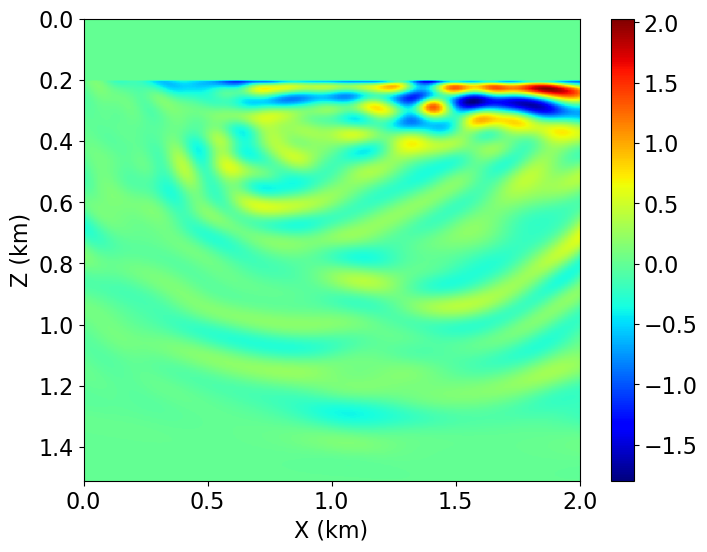

In [25]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(update.data.T[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]], extent=[xmin, xmax, zmax, zmin], cmap='jet', aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

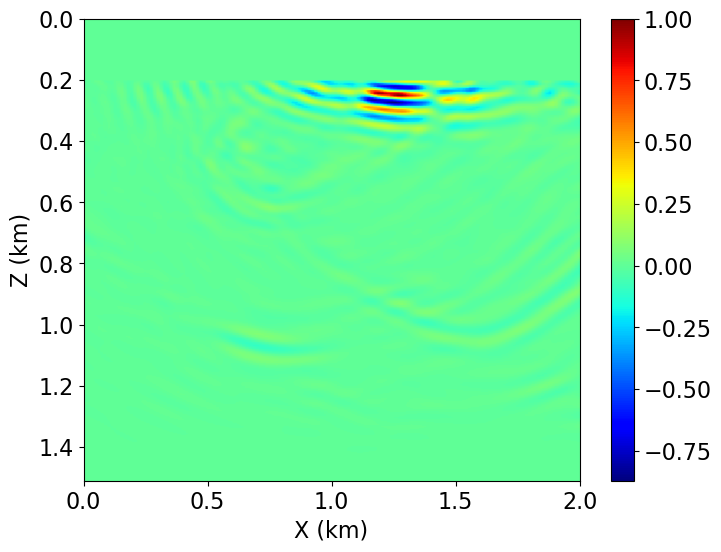

In [100]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(update.data.T[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]], extent=[xmin, xmax, zmax, zmin], cmap='jet', aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

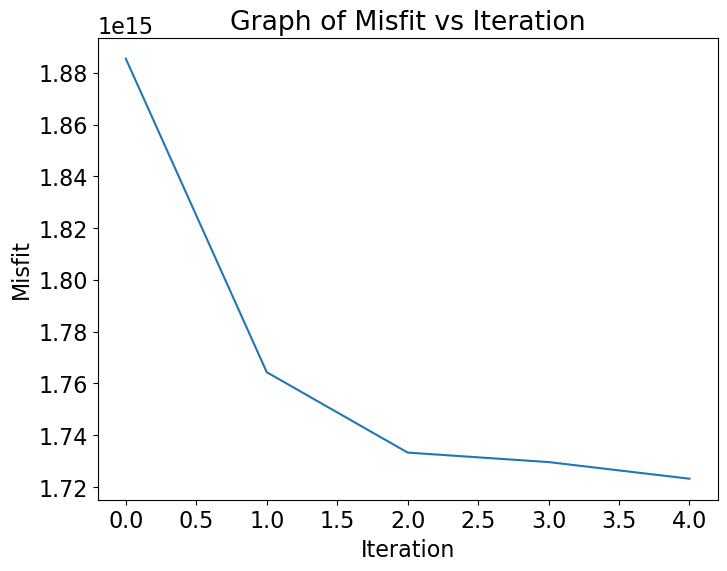

In [26]:
import matplotlib.pyplot as plt

plt.plot(misfiti)
plt.title("Graph of Misfit vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Misfit")
plt.show()

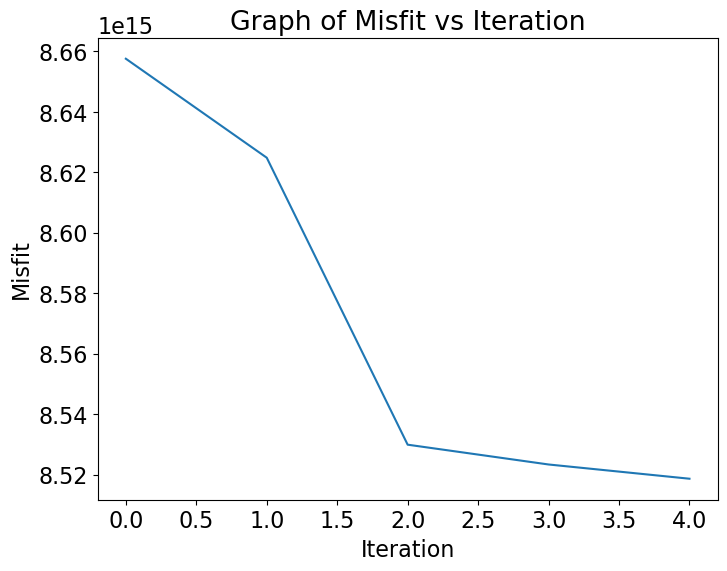

In [24]:
import matplotlib.pyplot as plt

plt.plot(misfiti)
plt.title("Graph of Misfit vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Misfit")
plt.show()

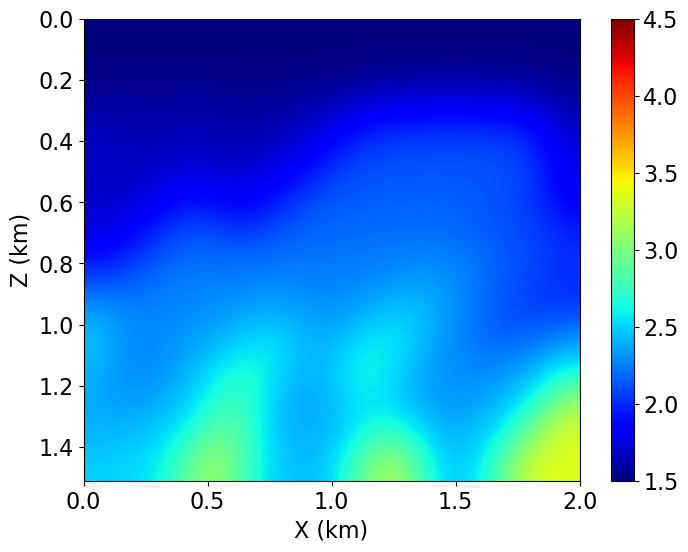

In [69]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(model0.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=4.5, aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

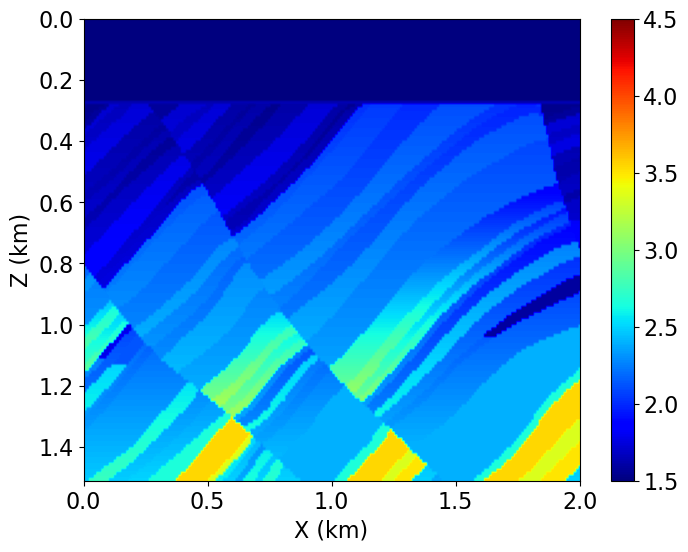

In [70]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=4.5, aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

In [71]:
len(modelbest_each_freq)

1

In [72]:
print(modelbest_each_freq[0] == modelbest_each_freq[2])

IndexError: list index out of range

In [89]:
model_test = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing, space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)

model_test_2 = deepcopy(model_test)

model_test_2.vp.data[:] = model_test.vp.data[:]*2


print(model_test == model_test_2)

False


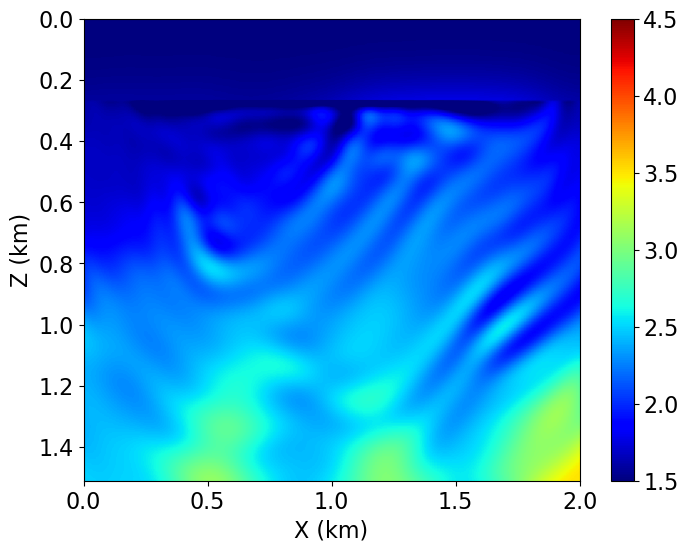

In [27]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(update_model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=4.5, aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

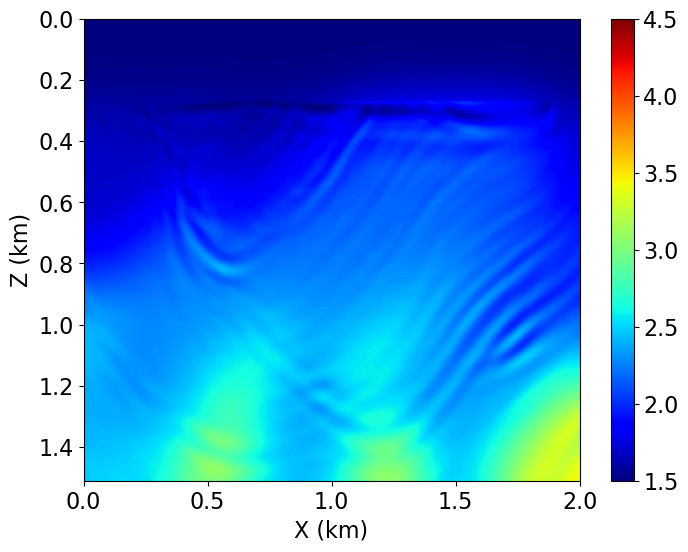

In [25]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(update_model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=4.5, aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

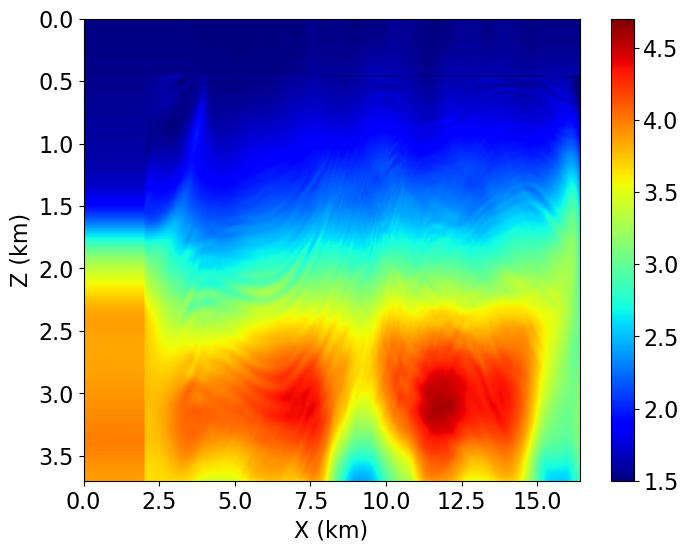

In [102]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(update_model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=4.7, aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

In [70]:
print(dt)

1.75


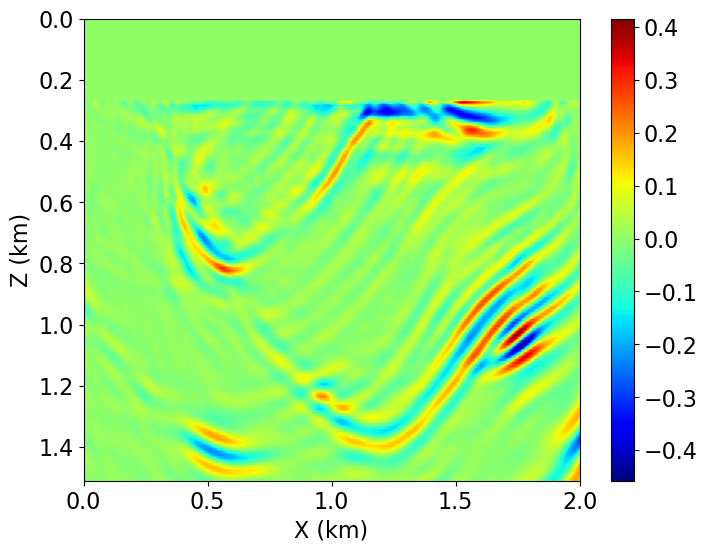

In [74]:
selisih_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model.vp.data[:] = update_model.vp.data[:] - model0.vp.data[:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

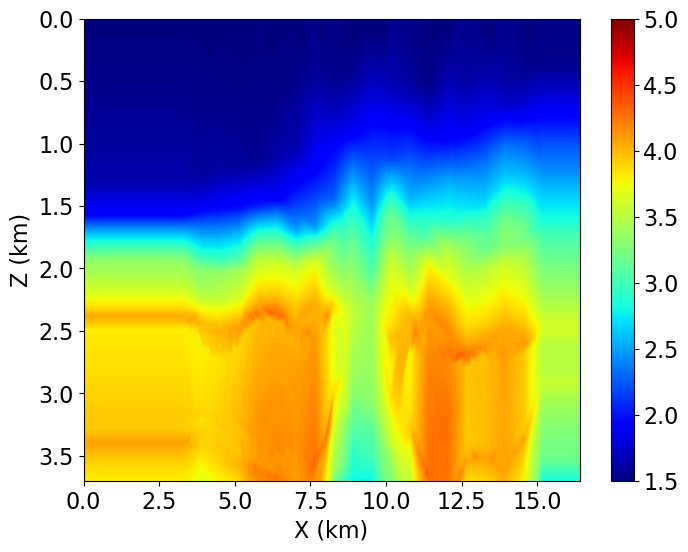

In [209]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=5.0, aspect='auto')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

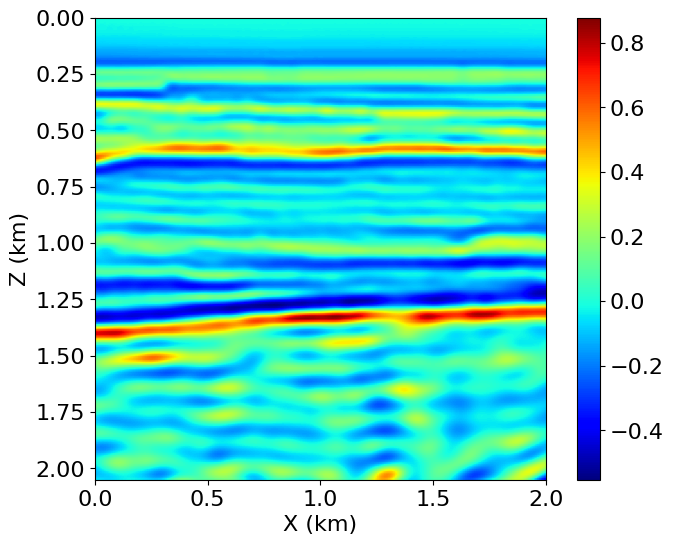

In [41]:
selisih_model1 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model1.vp.data[:] = model.vp.data[:] - model0.vp.data[:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model1.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

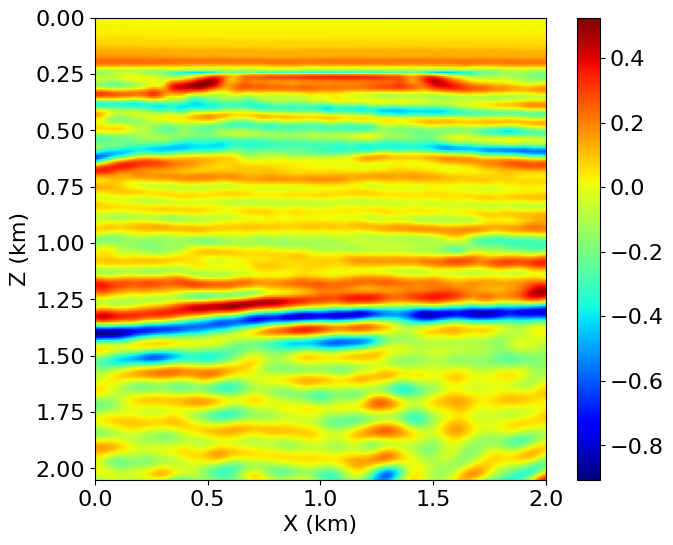

In [42]:
selisih_model2 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model2.vp.data[:] = modeli[ibest].vp.data[:] - model.vp.data[:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model2.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

In [41]:


geometrys[124].src_positions
geometrys[0].rec_positions[0]


array([0., 0.])

In [43]:
recs_coordinate = []

for i in range(nshots):
    recs_coordinate.append(geometrys[i].rec_positions)

In [44]:
recs_coordinate[0]

array([[   0.        ,    0.        ],
       [  25.47169811,    0.        ],
       [  50.94339623,    0.        ],
       [  76.41509434,    0.        ],
       [ 101.88679245,    0.        ],
       [ 127.35849057,    0.        ],
       [ 152.83018868,    0.        ],
       [ 178.30188679,    0.        ],
       [ 203.77358491,    0.        ],
       [ 229.24528302,    0.        ],
       [ 254.71698113,    0.        ],
       [ 280.18867925,    0.        ],
       [ 305.66037736,    0.        ],
       [ 331.13207547,    0.        ],
       [ 356.60377358,    0.        ],
       [ 382.0754717 ,    0.        ],
       [ 407.54716981,    0.        ],
       [ 433.01886792,    0.        ],
       [ 458.49056604,    0.        ],
       [ 483.96226415,    0.        ],
       [ 509.43396226,    0.        ],
       [ 534.90566038,    0.        ],
       [ 560.37735849,    0.        ],
       [ 585.8490566 ,    0.        ],
       [ 611.32075472,    0.        ],
       [ 636.79245283,   

In [50]:
recs_coordinate = np.array(recs_coordinate)
srcs_coordinate = np.array(geometrys[0].src_positions)

In [47]:
recs_coordinate.shape

(125, 160, 2)

In [51]:
import matplotlib.pyplot as plt

# Misalnya bentuk array kamu:
# receiver_coords shape: (nshot, nreceiver, 2)
# source_coords shape: (nshot, 2)

def plot_shot_gather(receiver_coords, source_coords, shot_idx):
    # Ambil koordinat untuk satu shot
    recs = receiver_coords[shot_idx]  # shape: (nreceiver, 2)
    src = source_coords[shot_idx]     # shape: (2,)

    plt.figure(figsize=(10, 5))
    plt.scatter(recs[:, 0], recs[:, 1], c='blue', label='Receiver', marker='v')
    plt.scatter(src[0], src[1], c='red', label='Source', marker='*', s=100)
    plt.title(f'Shot {shot_idx}')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.gca().invert_yaxis()  # karena Z biasanya ke bawah dalam data seismik
    plt.legend()
    plt.grid(True)
    plt.show()


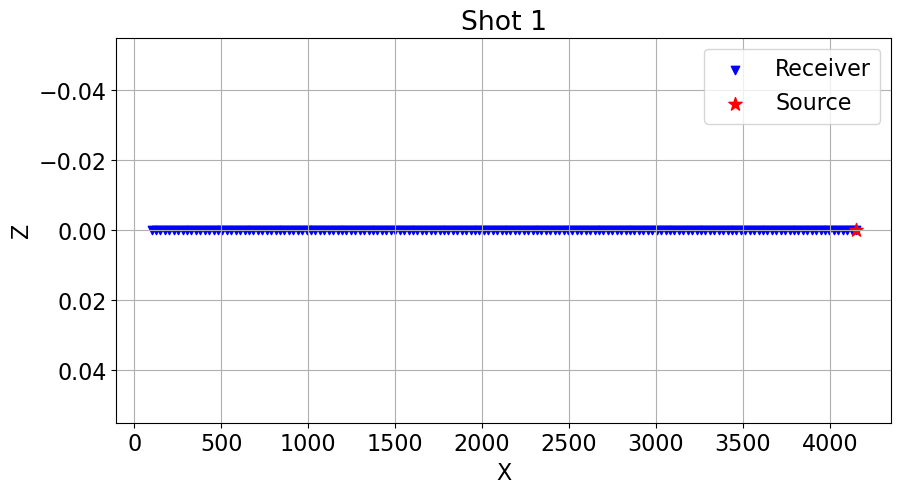

In [52]:
plot_shot_gather(recs_coordinate, srcs_coordinate, 1)

In [53]:
import matplotlib.pyplot as plt

def plot_all_shots(receiver_coords, source_coords):
    nshot = source_coords.shape[0]

    plt.figure(figsize=(12, 6))

    for shot in range(nshot):
        recs_x = receiver_coords[shot, :, 0]  # ambil hanya x receiver
        shot_num = [shot] * len(recs_x)       # y-nya: nomor shot yang sama

        # plot receiver
        plt.scatter(recs_x, shot_num, color='blue', s=5, label='Receiver' if shot == 0 else "")

        # plot source
        plt.scatter(source_coords[shot, 0], shot, color='red', marker='*', s=30, label='Source' if shot == 0 else "")

    plt.xlabel('X Coordinate')
    plt.ylabel('Shot Number')
    plt.title('Source & Receiver Coordinates per Shot')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


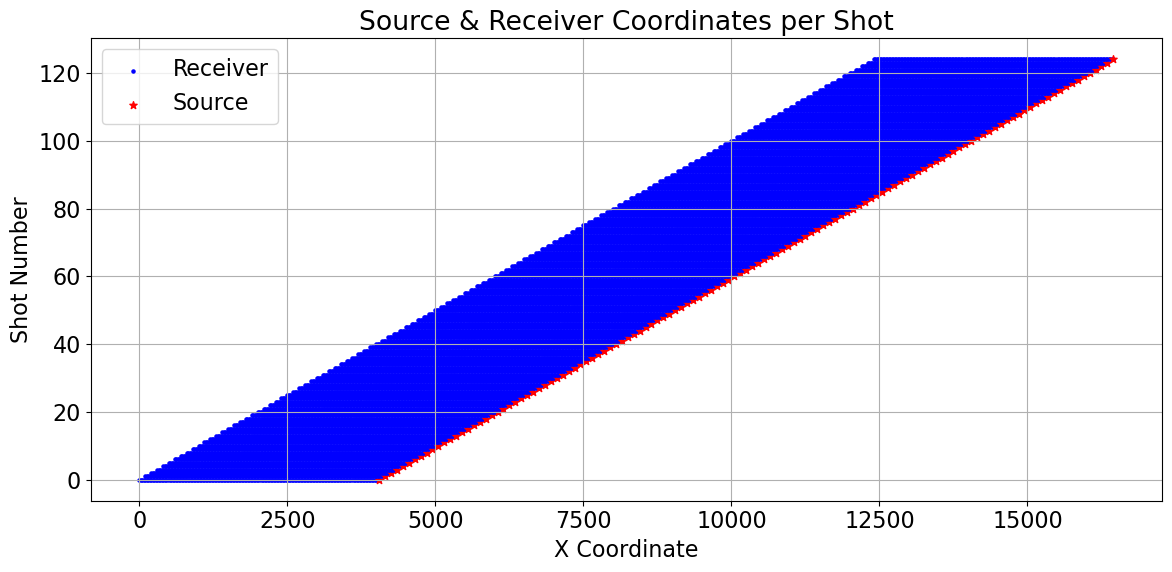

In [54]:
plot_all_shots(recs_coordinate, srcs_coordinate)